##### This script will associate spoken phrases with their corresponding translation, using Dynamic Time Warping (DTW) algorithm on MFCC of audio recordings.  

##### The previous workbook focused on F03, who has mild dysarthria, and achieved accuracy of 60 - 70% with only a single recording used as a training example. In this workbook, we repeat the experiment with M05 whose speech is less intelligible, and still achieve an accuracy of 70% (although there are only four target phrases, compared to 8 for F03)

## Dynamic Time Warping (DTW)

One of the challenges inherent in speech recognition is that the tenor of speech can vary, and this is particularly true for dysarthric speech, where imprecision is the result of disruption of muscular control. Although a dysarthric speaker will typically make consistent errors or distortions (which is why we are focusing on dysarthria rather than apraxia) they have difficulty with the speed of articulation, or with phoneme transitions, and the same phrase spoken by the same speaker may vary in length.

We could use Euclidian distance to compare the similarity of two signals of the same duration, but if we want to compare signals of different duration, we need to transform one of them. DTW is an algorithm that allows for a non-linear transformation of the time series, either compressing or stretching it, so that the distance between the two signals is minimized (ie the optimal alignment is achieved taking into account temporal distortions such as pauses or changes in speed).


![](img/DTW.png)

<sup>_image from E Keough, Dept of CS, UC Riverside_</sup>

In this example, the two signals are actually fairly similar, but the peaks occur at different times. Using simple Euclidean distance, we would compare periods of silence in one signal with periods of noise in the other, whereas DTW allows us to effectively warp the signal and compress offset periods of silence so that the signals are much better aligned and we can make a more accurate comparison. The mechanics are described in more detail at the bottom of this workbook. 

By applying DTW, we can compare an input phrase to a dictionary of labeled phrases of different durations, and compare the minimized distances to determine which labeled phrase most closely matches the input.

## 1) Load Packages

In [1]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

# import matplotlib.pylab as plt
from skimage import data, img_as_float
from skimage import exposure
import sklearn
import random
import itertools
import librosa
import librosa.display
import IPython.display as ipd

%matplotlib inline

## 2) Load Data and Compute MFCCs

In [102]:
df = pd.read_csv('../index_TORGO.txt', sep="|", converters={'prompt_id': lambda x: str(x)})

# Try M05, whose speech is more severely impaired than F03
df = df.loc[(df['speaker'] == 'M05') & (df['mic'] == 'wav_headMic')]

# Remove instances where prompt is None, ends with "]" or contains "jpg"
df['remove'] = (df['prompt']==None) | (df['prompt']=='None') | (df['prompt'].str.contains('jpg')) | (df['prompt'].str.endswith(']')) 
df = df.loc[df['remove'] == False]

# Now remove all instances of a single word, since we are trying to match phrases at this stage
df['remove'] = (df['prompt'].str.contains(' '))
df = df.loc[df['remove'] == True]

# Identify phrases that were recorded twice
df_filter = df.groupby(['prompt']).size().reset_index(name='counts')
df_filter = df_filter[df_filter['counts']==2]
df_filter


,prompt,counts
25,He further proposed grants of an unspecified s...,2
50,Mother sews yellow gingham aprons.,2
53,Nobody really expects to evacuate.,2
106,Why yell or worry over silly items?,2


So, at this stage, we have two recordings of four different phrases. This means that we can use one as a test file and compare it to the remaining recordings. Only one of those remaining recordings should be the correct match.

In [103]:
# Only keep examples that are recorded twice
df = df.merge(df_filter, on='prompt', how='inner')
df

,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove,counts
0,M05,Session2,wav_headMic,0042,yes,434,513,Mother sews yellow gingham aprons.,True,2
1,M05,Session2,wav_headMic,0043,yes,262,513,Mother sews yellow gingham aprons.,True,2
2,M05,Session2,wav_headMic,0055,yes,284,513,Why yell or worry over silly items?,True,2
3,M05,Session2,wav_headMic,0056,yes,288,513,Why yell or worry over silly items?,True,2
4,M05,Session2,wav_headMic,0145,yes,543,513,He further proposed grants of an unspecified s...,True,2
5,M05,Session2,wav_headMic,0146,yes,602,513,He further proposed grants of an unspecified s...,True,2
6,M05,Session2,wav_headMic,0313,yes,299,513,Nobody really expects to evacuate.,True,2
7,M05,Session2,wav_headMic,0314,yes,267,513,Nobody really expects to evacuate.,True,2


In [104]:
# Load data
mfcc = []
prompts = []
prompt_text = []
train = []

# Loop through each row of the dataframe
for p in range(df.shape[0]):
#     for i in range(1,11):
    aud_loc = aud_loc = '/'.join(['../data/TORGO', df['speaker'][p], df['session'][p], df['mic'][p], df['prompt_id'][p]+'.wav'])           
    data, rate = librosa.load(aud_loc)
    
    # Trim leading and trailing silence
    data, index = librosa.effects.trim(data, top_db=30)

    mfcc.append(librosa.feature.mfcc(data, rate))
    prompts.append(p//2) # Each pair of audio files has the same prompt
    prompt_text.append(df['prompt'][p])
    train.append(1 if (p+2) % 2== 0 else -1) # Assign every other record to train

In [105]:
print(train)
print(prompts)

[1, -1, 1, -1, 1, -1, 1, -1]
[0, 0, 1, 1, 2, 2, 3, 3]


In [106]:
# Scale features
for i,x in enumerate(mfcc): 

    mfcc[i] = sklearn.preprocessing.scale(mfcc[i], axis=1)
    
print(mfcc[0].shape)

(20, 329)


{0: 'Mother sews yellow gingham aprons.', 1: 'Why yell or worry over silly items? ', 2: 'He further proposed grants of an unspecified sum for experimental hospitals.', 3: 'Nobody really expects to evacuate.'}


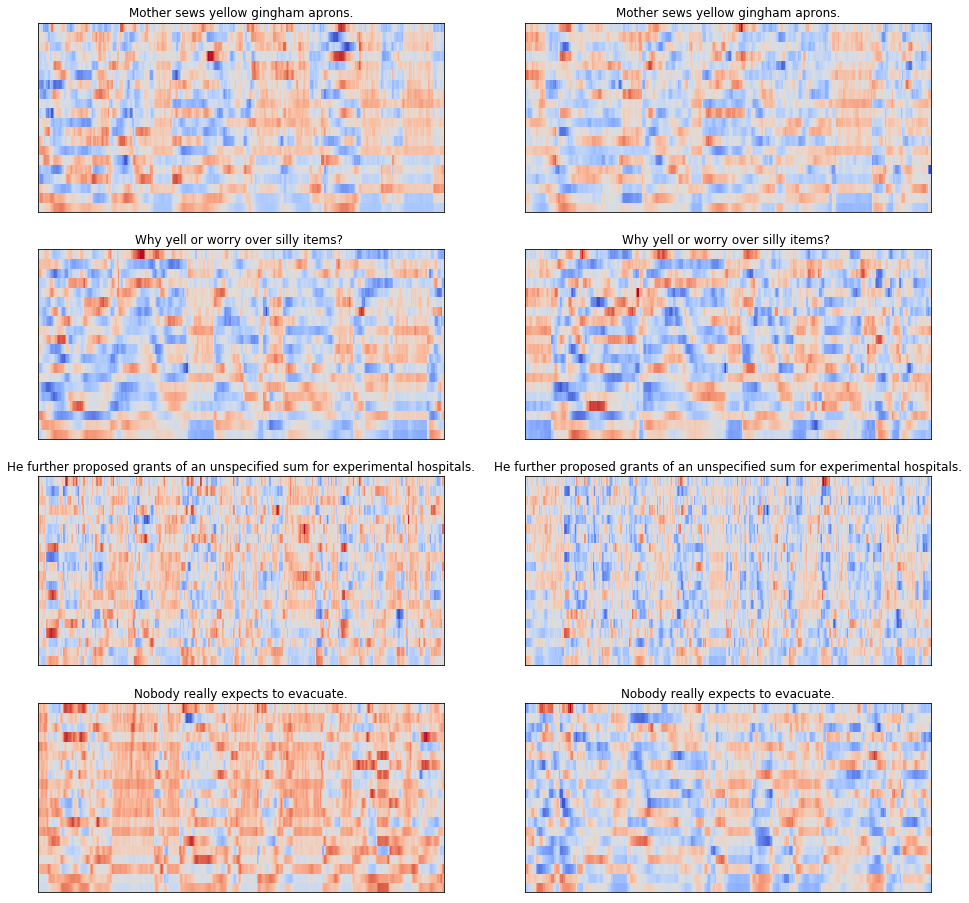

In [107]:
cat = dict(zip(prompts, prompt_text))  # Dictionary to look up prompt text from prompt code
num_examples = 8

fig = plt.figure(figsize=(16, 16))

for i in range(num_examples):
    plt.subplot(4,2,i+1)
    librosa.display.specshow(mfcc[i])
    plt.title(cat.get(prompts[i]))
    
print(cat)

In [108]:
aud_loc1 = '../data/TORGO/M05/Session2/wav_headMic/0042.wav'
aud_loc2 = '../data/TORGO/M05/Session2/wav_headMic/0043.wav'

data1, rate1 = librosa.core.load(aud_loc1)
ipd.Audio(data1, rate=rate1)

In [109]:
# Trim leading and trailing silence (a whisper is usually around 25 to 30 decibels)
data1, index = librosa.effects.trim(data1, top_db=30)
ipd.Audio(data1, rate=rate1)

In [110]:
data2, rate2 = librosa.core.load(aud_loc2)
ipd.Audio(data2, rate=rate2)

## 3) Compare using DTW

In [111]:
from scipy.spatial.distance import euclidean
from numpy.linalg import norm
from fastdtw import fastdtw, dtw

In [112]:
x_train = [mfcc[i] for i,x in enumerate(train) if x==-1]
y_train = [prompts[i] for i,x in enumerate(train) if x==-1]
x_test = [mfcc[i] for i,x in enumerate(train) if x==1]
y_test = [prompts[i] for i,x in enumerate(train) if x==1]
print('# train: ', len(y_train))
print('# test: ', len(y_test))

# train:  4
# test:  4


In [133]:
# Calculate the DTW distance

master_dist = []
for i,x in enumerate(x_test):
    mfcc_dist = []
    # For each shift -/+ 100, in multiples of 10
    for d in range(-100, 101, 10):
        dist = []
        for i2,x2 in enumerate(x_train):
            distance, path = fastdtw(np.roll(x,d).T, x2.T, dist=lambda x, y: norm(x - y))
            dist.append(distance)
        mfcc_dist.append(dist)
    master_dist.append(mfcc_dist)
    

pd.DataFrame(master_dist[0])

# # Get the index of the matching prompt: remember that we've removed one example
# # to act as the test, so we need to add one to the index of the result if we use
# # it to lookup the prompt text in the original dataframe
# matching_prompt = int(pd.DataFrame(mfcc_dist).idxmin())+1
# print('Test prompt: {0}'.format(prompt_text[0]))
# print('Best match: Number {0} = {1}'.format(matching_prompt-1, prompt_text[matching_prompt]))
# pd.DataFrame(mfcc_dist)

,0,1,2,3
0,1959.069301,1916.575572,4377.776199,1961.215651
1,1878.982148,1877.565683,4230.390828,1928.012917
2,1931.609086,1937.240791,4538.033447,1997.210509
3,1938.491601,1991.341651,4377.376808,1881.363507
4,1943.234303,2019.800712,4302.326346,1890.377607
5,1818.264477,1937.353708,4250.846873,1858.043508
6,1813.502493,1861.614037,4253.952114,1931.575331
7,1974.136144,1863.925382,4538.567048,1831.136864
8,1971.862890,1987.537749,4509.008293,1813.841992
9,1930.946329,1915.438532,4274.073496,1875.532009


In [139]:
# DETERMINE PREDICTIONS

prediction_overalldist = []
votes = []

# Loop through each training example
for i,x in enumerate(master_dist):
    vote = []
    # For each of the shifted vectors, get the prediction with min distance - the votes
    min_dist = 1000000
    for i2,x2 in enumerate(x):
        vote.append(x2.index(min(x2)))

        # Save the overall min distance from all shifted vectors = overall closest prediction
        if min(x2) < min_dist:
            min_dist = min(x2)
            min_overall = x2.index(min(x2))
        
    # Overall closest prediction out of the shifted MFCC vectors - the final vote
    prediction_overalldist.append(min_overall)
    
    # Track votes - determine if some vectors perform worse
    votes.append(vote)
    

In [140]:
num_correct_overall = 0

print('----------------------------------------------------------------------')
print('Correct|Prediction|MFCC Predictions')
for i,x in enumerate(votes):
    print(y_test[i], '|', prediction_overalldist[i], x)
    if y_test[i] == prediction_overalldist[i]: num_correct_overall += 1
print('----------------------------------------------------------------------')    
print('% Correct (Overall):', num_correct_overall / len(y_test) * 100)

----------------------------------------------------------------------
Correct|Prediction|MFCC Predictions
0 | 0 [1, 1, 0, 3, 3, 0, 0, 3, 3, 3, 3, 0, 1, 3, 0, 3, 3, 0, 0, 1, 0]
1 | 1 [3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]
2 | 3 [3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 1, 1]
3 | 3 [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 1]
----------------------------------------------------------------------
% Correct (Overall): 75.0


#### NOTES:

1. Assuming there are 4 unique stored phrases, I tested comparing the second recording of each to the 4 stored examples and got 50% accuracy. Some of the recordings have a lot of silence at the beginning, so it could help to trim this.

2. Trimming silence below 30 decibels got an additional test phrase correct, brining it to 75% accuracy. Further examine below the one it got wrong. Lets try more shifts and a larger range of shifts, because the phrase it is getting wrong is longer than all of the recordings I made of myself.

3. More shifts (-/+ 30 step 5) still gets it wrong. The issue may be that this vector is much wider than the others. We can improve the speed and accuracy of our algorithm by only running DTW comparisons to stored phrases that are within a certain threshold of seconds. The MFCC vector for this phrase is 764 columns wide (x_train[2].shape). The other 3 phrases are all around 250. That is a much bigger difference. Lets try larger shifts and steps.

4. Shifts (-/+ 50 step 10) still did not work. Lets try even larger range.

5. Shifts (-/+ 100 step 10) did not work.

In [99]:
# "He further proposed grants of an unspecified sum for experimental hospitals"
# It is confusing this phrase for "Nobody really expects to evacuate."
# Idea: These would not even be compared if we has a seconds threshold to run comparisons. 

aud_loc1 = '../data/TORGO/M05/Session2/wav_headMic/0145.wav'
aud_loc2 = '../data/TORGO/M05/Session2/wav_headMic/0146.wav'

data1, rate1 = librosa.core.load(aud_loc1)
data1, index = librosa.effects.trim(data1, top_db=30) # Trim
ipd.Audio(data1, rate=rate1)

In [100]:
data2, rate2 = librosa.core.load(aud_loc2)
data2, index = librosa.effects.trim(data2, top_db=30) # Trim
ipd.Audio(data2, rate=rate2)

## Further background - Mechanics of the DTW algorithm

To calculate the DTW distance between two vectors X and Y, the first step is to create a matrix of size |Y| by |X| where the elements are the distance between every pair of points in the vectors, where distance is measured using the following methodology:

_To calculate the element [i,j] (ie the distance between the vector elements $Y_{i}$ and $X_{j}$), take the absolute value of $Y_{i}$ - $X_{j}$ and then add the minimum value of the three adjacent cells to the left, diagonal below left and below, ie cells [i-1, j], [i-1, j-1], [i, j-1]._

So, for example, if the two vectors we wish to compare are X = [1,6,2,3,0,9,4,3,6,3] and Y = [1,3,4,9,8,2,1,5,7,3] we would build the following cost matrix

![](img/DTW_matrix.png)

Cell [3,3] in bold with a value of 11 is calculated as |$Y_{3}$ - $X_{3}$| = |9-3| = 6, **plus** the minimum of the three adjacent cells to the left and below, ie left = 11, left diagonal below = 5, below = 5, so min{11,5,5) = 5. Along the edges where there are a limited number of adjacent cells, just add whichever cell is present, which will either be one to the left or one below (note that the diagram above incorrectly highlights cell [0,8], but the calculation provided is for the bold cell [0,4] with a value of 20)

Once the matrix is populated, it is possible to find the minimum distance between the start and ending points by selecting the cell in the top right corner, and then tracing a path back to the origin by successively choosing whichever cell in the three adjacent cells to the left and below contains the lowest value

![](img/DTW_path.png)

Starting with the top right cell [9,9], the cell to the left = 18, left diagonal below = 15, below = 18, so we select left diagonal below. Then the adjacent cells are left = 18, left diagonal below = 15, below = 14, so we select below. In this way, a warping path is traced back to the origin, and that path reveals which points in Y should map to points in X

![](img/warping_path.png)

It is common practice to apply a weighting function to the overall distance (ie the sum of the elements along the warping path) to normalize for the path length. This weighting can either be based upon the distance travelled along either the X axis, or along both X and Y.